# **STEP 17.3:** Machine Learning Model #3 - Adaboost

In [1]:
import pandas as pd
import random as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

### Isodose + ROI - Delta Radiomics + Clinical Features

In [2]:
absolute_data_isodose_roi = pd.read_csv("/notebooks/disk2/CSV_Dataset/07_RF_Treatment_Clinical.csv")

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"2nd Treatment": 1})
)

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"Follow-up": 0})
)

X = absolute_data_isodose_roi.drop(columns=['Patient ID', 'Mask Name','Decision', 'First Treatment', 'First Follow-Up'])
y = absolute_data_isodose_roi["Decision"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("-------")
print(X.shape)
print(y.value_counts())
print("-------")

# OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)


X_encoded = preprocessor.fit_transform(X)

# Split train/test
x_train, x_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("-------")
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}\n")
print(f"Train Distribution:\n{pd.value_counts(y_train)}\n")
print(f"Test Distribution:\n{pd.value_counts(y_test)}")
print("-------")


-------
(177, 1326)
Decision
1    132
0     45
Name: count, dtype: int64
-------
-------
Training set: (141, 1339), Test set: (36, 1339)

Train Distribution:
Decision
1    105
0     36
Name: count, dtype: int64

Test Distribution:
Decision
1    27
0     9
Name: count, dtype: int64
-------


### Define best parameters

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'n_estimators': 100, 'learning_rate': 0.1}
Best CV F1: 0.9773643410852714
Accuracy: 1.0
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00       105

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Confusion Matrix (Train):
 [[ 36   0]
 [  0 105]]


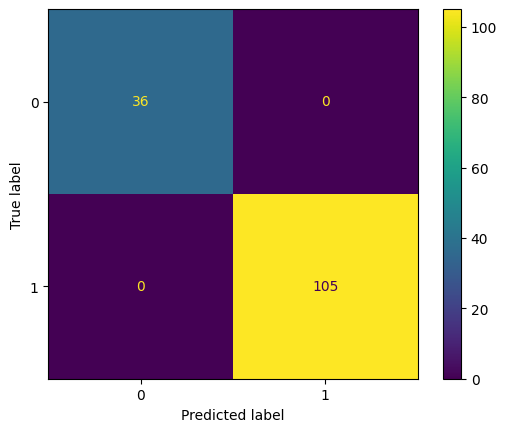

In [7]:
weak_learner = DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=42)

adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    random_state=42
)

param_dist = {
    "n_estimators": [30, 40, 50, 100],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=adaboost_clf,
    param_distributions=param_dist,
    n_iter=16,  
    scoring="f1",   
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score (F1):", random_search.best_score_)

best_ada = random_search.best_estimator_
y_pred = best_ada.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report (Train):\n", classification_report(y_train, y_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_pred))

ConfusionMatrixDisplay.from_estimator(best_ada, x_train, y_train)
plt.show()


Accuracy: 0.9722222222222222
Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.96      1.00      0.98        27

    accuracy                           0.97        36
   macro avg       0.98      0.94      0.96        36
weighted avg       0.97      0.97      0.97        36

Confusion Matrix (Test):
 [[ 8  1]
 [ 0 27]]


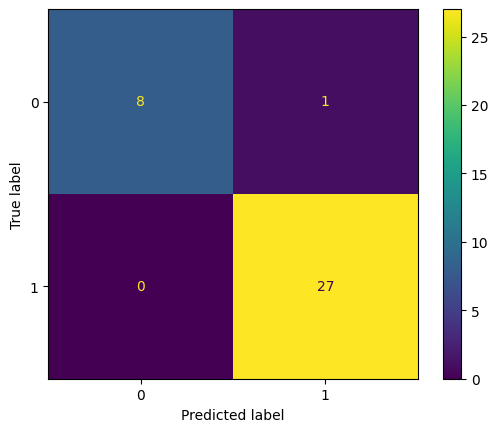

In [8]:
y_pred = best_ada.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_ada, x_test, y_test)
plt.show()

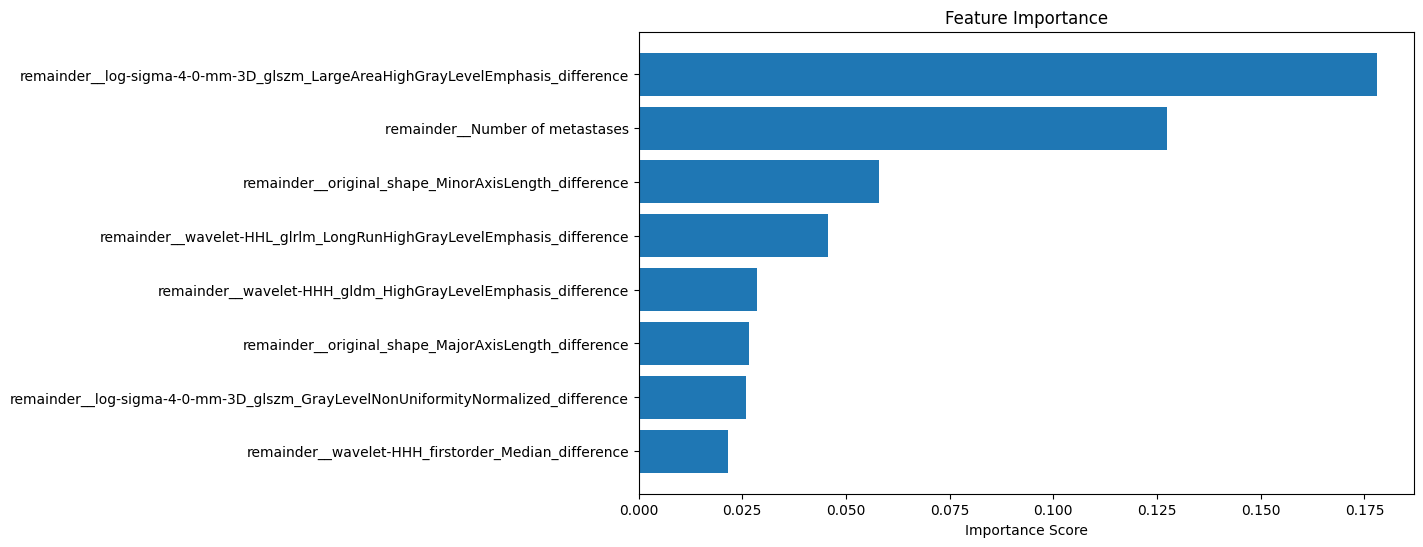

In [9]:
importances = best_ada.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(8), importances[indices][:8], align="center")
plt.yticks(range(8), feature_names[indices][:8])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.show()